In [1]:
%load_ext autoreload
%autoreload 2

import json


import pymc as pm
import arviz as az

import numpy as np

import pytensor
from pytensor import tensor as pt
from pytensor.graph.basic import Apply
from pytensor.graph import Apply, Op
from pytensor.tensor.type import TensorType

import aesara
import aesara.tensor as at
# from aesara.graph.op import Op
from aesara.link.jax.dispatch import jax_funcify

import jax
from jax import grad, jit, vmap, value_and_grad, random
import jax.numpy as jnp


# import sys
# sys.path.insert(1, '/Users/malinhorstmann/Documents/pyhf_pymc/src')
import MH_inference
import HMC_inference
import prepare_inference

import matplotlib.pyplot as plt

import pyhf
pyhf.set_backend('jax')

import corner

## Model

In [2]:
### Simple pyhf model
model = pyhf.Model(
    {'channels': [{'name': 'singlechannel',
    'samples': [
    {'name': 'signal',
     'data': [6, 6, 10],
     'modifiers': [
         {'name': 'mu', 'type': 'normfactor', 'data': None}]},

    {'name': 'background',
     'data': [550, 550, 550]
     ,
     'modifiers': [
        ## Staterror / Normal
        {"name": "my_staterror","type": "staterror","data": [2.0, 2.0, 2.0],},
        ## Lumi / Normal
        # {'name': 'lumi', 'type': 'lumi', 'data': None},
        ## Correlated / Normal
        # {'name': 'corr_bkg', 'type': 'histosys','data': {'hi_data': [65, 56, 67], 'lo_data': [40, 40, 43]}},
        # {'name': 'corr_bkg1', 'type': 'histosys','data': {'hi_data': [65, 56, 67], 'lo_data': [40, 40, 43]}},
        # {'name': 'corr_bkg2', 'type': 'histosys','data': {'hi_data': [65, 56, 67], 'lo_data': [40, 40, 43]}},
        # ## Uncorrelated / Poisson
        # {'name': 'uncorr_bkg', 'type': 'shapesys','data': [7, 8, 7.17]},
        # {'name': 'uncorr_bkg1', 'type': 'shapesys','data': [7, 8, 7.17]},
        # {'name': 'uncorr_bkg2', 'type': 'shapesys','data': [7, 8, 7.17]},
        
         ]
         },    
                                 
    ]},
    ]
    # ,
    # "parameters": [
    #         {
    #             "name": "lumi",
    #             "auxdata": [1.0],
    #             "sigmas": [0.017],
    #             "bounds": [[0.915, 1.085]],
    #             "inits": [1.0],
    #         }],
        }
)

obs = model.expected_actualdata(model.config.suggested_init())

nBins = len(model.expected_actualdata(model.config.suggested_init()))
nPars = len(model.config.suggested_init())

In [57]:
# with open('SRee_SRmm_Srem.json') as serialized:
with open('ttbar_ljets_xsec_inclusive_pruned.json') as serialized:
    spec = json.load(serialized)

workspace = pyhf.Workspace(spec)
model = workspace.model()

obs = workspace.data(model, include_auxdata=False)

nBins = len(model.expected_actualdata(model.config.suggested_init()))
nPars = len(model.config.suggested_init())

In [3]:
# Prepare the priors for sampling
    # Unconstrained parameters
unconstr_dict = {
    'uncon1': {'type': 'unconstrained', 'type2': 'normal', 'input': [[50], [1]]}
    }

    # Create dictionary with all priors (unconstrained, constrained by normal and poisson)
prior_dict = prepare_inference.prepare_priors(model, unconstr_dict)

    # dictionary with keys 'model', 'obs', 'priors', 'precision'
prepared_model = prepare_inference.prepare_model(model=model, observations=obs, precision=1, priors=prior_dict)

## General Functions

In [4]:
# Jax expected data
@jax.jit
def processed_expData(parameters):
    a = jnp.stack([model.expected_actualdata(parameters)[i] for i in range(nBins)])
    return a

one_vector = np.full(nBins, 1., dtype='float64')

# Gradient list (dn_bins/dx_1, ..., dn_bins/dx_nPars)
@jax.jit
def vjp_expData(parameters):
    _,back = jax.vjp(processed_expData, parameters)
    return back(one_vector)

In [106]:
# Parameter options
eval_point = model.config.suggested_init()
pars = prepare_inference.priors2pymc(prepared_model)
print(pars.type)

TensorType(float64, (4,))


## Hamiltonian MC

### Gradient Op

In [165]:
# class VJPOp(pt.Op):

#     def make_node(self, parameters):
#         # self.vjp_func = vjp_expData
#         inputs = [pt.as_tensor_variable(parameters)]
#         outputs = [pt.vector()]
        
#         return Apply(self, inputs, outputs)

#     def perform(self, node, inputs, outputs):
#         (parameters,) = inputs
#         results = vjp_expData(parameters)

#         if not isinstance(results, (list, tuple)):
#                 results = (results,)
                
#         for i, r in enumerate(results):
#             outputs[i][0] = np.asarray(r)

# vjp_op = VJPOp()

# class VJPOp(pt.Op):

#     def make_node(self, parameters):
#         # self.vjp_func = vjp_expData
#         inputs = [pt.as_tensor_variable(parameters)]
#         outputs = [pt.vector()]
        
#         return Apply(self, inputs, outputs)

#     def perform(self, node, inputs, outputs):
#         (parameters,) = inputs
#         results = vjp_expData(parameters)

#         if not isinstance(results, (list, tuple)):
#                 results = (results,)
                
#         for i, r in enumerate(results):
#             outputs[i][0] = np.asarray(r)

# vjp_op = VJPOp()

### Non-Gradient Op

In [9]:
# class ExpDataOp(pt.Op):
    
#     def make_node(self, parameters):
#         inputs = [pt.as_tensor_variable(parameters)]
#         outputs = [pt.vector()]

#         return Apply(self, inputs, outputs)

#     def perform(self, node, inputs, outputs):
#         (parameters, ) = inputs
#         results = processed_expData(parameters)

#         if len(outputs) == 1:
#                 outputs[0][0] = np.asarray(results)
#                 return
#         for i, r in enumerate(results):
#                 outputs[i][0] = np.asarray(r)

#     def grad(self, parameters):
#         return [vjp_op(parameters)]
        
# expData_op = ExpDataOp()

class ExpDataOp(pt.Op):
    
    def make_node(self, parameters):
        inputs = [pt.as_tensor_variable(parameters)]
        outputs = [pt.vector()]

        return Apply(self, inputs, outputs)

    def perform(self, node, inputs, outputs):
        (parameters, ) = inputs
        results = processed_expData(parameters)

        if len(outputs) == 1:
                outputs[0][0] = np.asarray(results)
                return
        for i, r in enumerate(results):
                outputs[i][0] = np.asarray(r)

    def grad(self, parameters):
        return [vjp_op(parameters)]
        
expData_op = ExpDataOp()

### Sampling

In [10]:

with pm.Model():
    pars = prepare_inference.priors2pymc(prepared_model)

    expData_op = ExpDataOp()
    ExpData = pm.Normal("ExpData", mu=expData_op(pars), sigma=10, observed=obs)

    post_data = pm.sample(150)
    post_pred = pm.sample_posterior_predictive(post_data)
    prior_pred = pm.sample_prior_predictive(150)

print(model.expected_actualdata(eval_point))
az.summary(post_pred, var_names="ExpData")


Only 150 samples in chain.


TypeError: grad() takes 2 positional arguments but 3 were given

In [170]:
with pm.Model():
    pars = prepare_inference.priors2pymc(prepared_model)

    expData_op = ExpDataOp()
    ExpData = pm.Normal("ExpData", mu=expData_op(pars), sigma=10, observed=obs)
    # ExpData = pm.Poisson("ExpData", mu=expData_op(pars), observed=obs)

    post_data = pm.sample(1500)
    post_pred = pm.sample_posterior_predictive(post_data)
    prior_pred = pm.sample_prior_predictive(1500)

print(model.expected_actualdata(eval_point))
az.summary(post_pred, var_names="ExpData")

# print(eval_point)
# az.summary(post_data)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [Unconstrained]
>Metropolis: [Normals]
CompoundStep
>Metropolis: [Unconstrained]
>Metropolis: [Normals]


Sampling 4 chains for 1_000 tune and 1_500 draw iterations (4_000 + 6_000 draws total) took 1 seconds.


Sampling: [ExpData, Normals, Unconstrained]


[556. 556. 560.]


/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/arviz/stats/stats.py:1351: UserWarning: Selecting first found group: posterior_predictive
  warnings.warn(f"Selecting first found group: {data.groups()[0]}")


mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
ExpData[0]  662.440  10.868  641.252  682.262      0.175    0.124    3849.0   
ExpData[1]  662.417  10.811  642.395  682.552      0.175    0.124    3826.0   
ExpData[2]  737.742  11.711  715.429  758.669      0.219    0.155    2855.0   

            ess_tail  r_hat  
ExpData[0]    4591.0    1.0  
ExpData[1]    5086.0    1.0  
ExpData[2]    3890.0    1.0

### Plotting

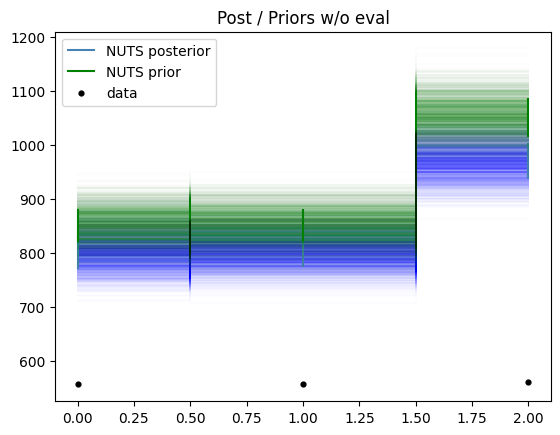

In [162]:
# Posterior predictive HMC
plt.step(np.linspace(0,nBins-1,nBins),post_pred.posterior_predictive.ExpData[0].T, alpha = 0.01, c = 'blue', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred.posterior_predictive.ExpData[0],[.15,.85],axis=0), colors = 'steelblue', label='NUTS posterior')

plt.step(np.linspace(0,nBins-1,nBins),prior_pred.prior_predictive.ExpData[0].T, alpha = 0.01, c = 'green', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_pred.prior_predictive.ExpData[0],[.15,.85],axis=0), colors = 'green', label='NUTS prior');

# Posterior predictive MH
# plt.step(np.linspace(0,nBins-1,nBins),post_pred_MH.posterior_predictive.ExpData[0].T, alpha = 0.01, c = 'pink', where = 'mid');
# plt.vlines(np.arange(nBins),*np.quantile(post_pred_MH.posterior_predictive.ExpData[0],[.15,.85],axis=0), colors = 'pink', label='Metropolis')

# Observations
plt.scatter(np.arange(nBins), obs, c = 'k',s=12, zorder = 999, label = "data")
plt.legend(loc='upper left')

plt.title(f'Post / Priors w/o eval')

plt.savefig('NUTS_updating')
plt.show()

In [ ]:
# az.plot_trace(post_data)

## Metropolis-Hastings

### Non-Gradient Op

In [126]:
class ExpDataOp_MH(pt.Op):
    """

    """
    itypes = [pt.dvector]  
    otypes = [pt.dvector]  

    def __init__(self, parameters):
        self.parameters = parameters

    def perform(self, node, parameters, outputs):
        ## Method that is used when calling the Op
        (theta,) = parameters  # Contains my variables

        ## Calling input function (in our case the model.expected_actualdata)
        result = processed_expData(theta)

        ## Output values of model.expected_actualdata
        outputs[0][0] = np.asarray(result)#, dtype=node.outputs[0].dtype)

### Sampling

In [159]:
with pm.Model():

    pars = prepare_inference.priors2pymc(prepared_model)
    
    expData_op_MH = ExpDataOp_MH(pars)
    # ExpData_MH = pm.Normal('ExpData', mu=expData_op_MH(pars), sigma = 0.05, observed=obs)
    ExpData_MH = pm.Poisson('ExpData', mu=expData_op_MH(pars), observed=obs)

    post_data_MH = pm.sample(1500)
    post_pred_MH = pm.sample_posterior_predictive(post_data_MH)
    prior_pred_MH = pm.sample_prior_predictive(1500)

print(model.expected_actualdata(eval_point))
az.summary(post_pred_MH, var_names="ExpData")

# print(eval_point)
# az.summary(post_data_MH)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [Unconstrained]
>Metropolis: [Normals]
CompoundStep
>Metropolis: [Unconstrained]
>Metropolis: [Normals]


Sampling 4 chains for 1_000 tune and 1_500 draw iterations (4_000 + 6_000 draws total) took 1 seconds.


Sampling: [ExpData, Normals, Unconstrained]


[556. 556. 560.]


/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/arviz/stats/stats.py:1351: UserWarning: Selecting first found group: posterior_predictive
  warnings.warn(f"Selecting first found group: {data.groups()[0]}")


mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
ExpData[0]  801.138  28.540   748.0    854.0      0.382    0.270    5601.0   
ExpData[1]  801.680  28.862   744.0    852.0      0.386    0.273    5603.0   
ExpData[2]  968.742  32.039   908.0   1027.0      0.509    0.361    3979.0   

            ess_tail  r_hat  
ExpData[0]    5920.0    1.0  
ExpData[1]    5768.0    1.0  
ExpData[2]    4463.0    1.0

### Plotting

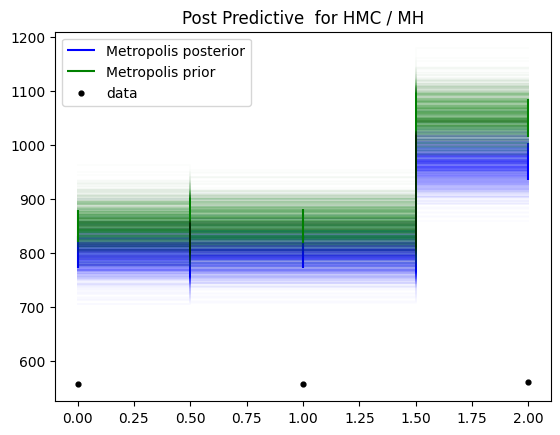

In [160]:
# Posterior predictive HMC
plt.step(np.linspace(0,nBins-1,nBins),post_pred_MH.posterior_predictive.ExpData[0].T, alpha = 0.01, c = 'blue', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred_MH.posterior_predictive.ExpData[0],[.15,.85],axis=0), colors = 'blue', label='Metropolis posterior')

plt.step(np.linspace(0,nBins-1,nBins),prior_pred_MH.prior_predictive.ExpData[0].T, alpha = 0.01, c = 'green', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_pred_MH.prior_predictive.ExpData[0],[.15,.85],axis=0), colors = 'green', label='Metropolis prior');

# Posterior predictive MH
# plt.step(np.linspace(0,nBins-1,nBins),post_pred_MH.posterior_predictive.ExpData[0].T, alpha = 0.01, c = 'pink', where = 'mid');
# plt.vlines(np.arange(nBins),*np.quantile(post_pred_MH.posterior_predictive.ExpData[0],[.15,.85],axis=0), colors = 'pink', label='Metropolis')

# Observations
plt.scatter(np.arange(nBins), obs, c = 'k',s=12, zorder = 999, label = "data")
plt.legend(loc='upper left')

plt.title(f'Post Predictive  for HMC / MH')

plt.savefig('metropolis_updating')
plt.show()

In [ ]:
az.plot_trace(post_data_MH)

## Testing the parameter order again

-> Also looks good

{'corr_bkg': {'slice': slice(0, 1, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x1640ee460>},
 'corr_bkg1': {'slice': slice(1, 2, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x1640ee3a0>},
 'corr_bkg2': {'slice': slice(2, 3, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x1640ee370>},
 'lumi': {'slice': slice(3, 4, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x1640ee520>},
 'mu': {'slice': slice(4, 5, None),
  'paramset': <pyhf.parameters.paramsets.unconstrained at 0x1640ee4c0>},
 'uncorr_bkg': {'slice': slice(5, 8, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_poisson at 0x1640ee550>},
 'uncorr_bkg1': {'slice': slice(8, 11, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_poisson at 0x1640ee580>},
 'uncorr_bkg2': {'slice': slice(11, 14, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_poisson at 0x1640ee4f0>},
 'my_staterror': {

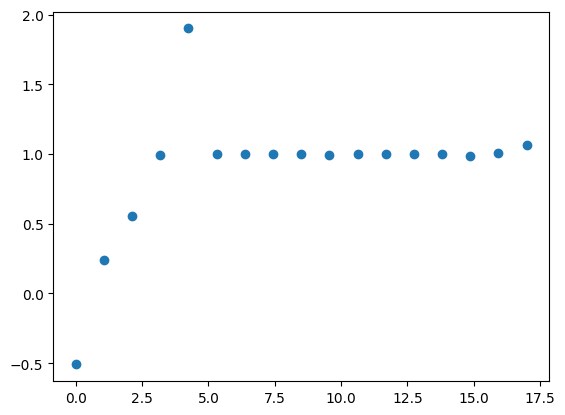

In [27]:
test = []
pars = prepare_inference.priors2pymc(prepared_model)
for i in range(nPars):
    test.append(pars[i].eval())

plt.scatter(np.linspace(0, nPars, nPars), test)

model.config.par_map

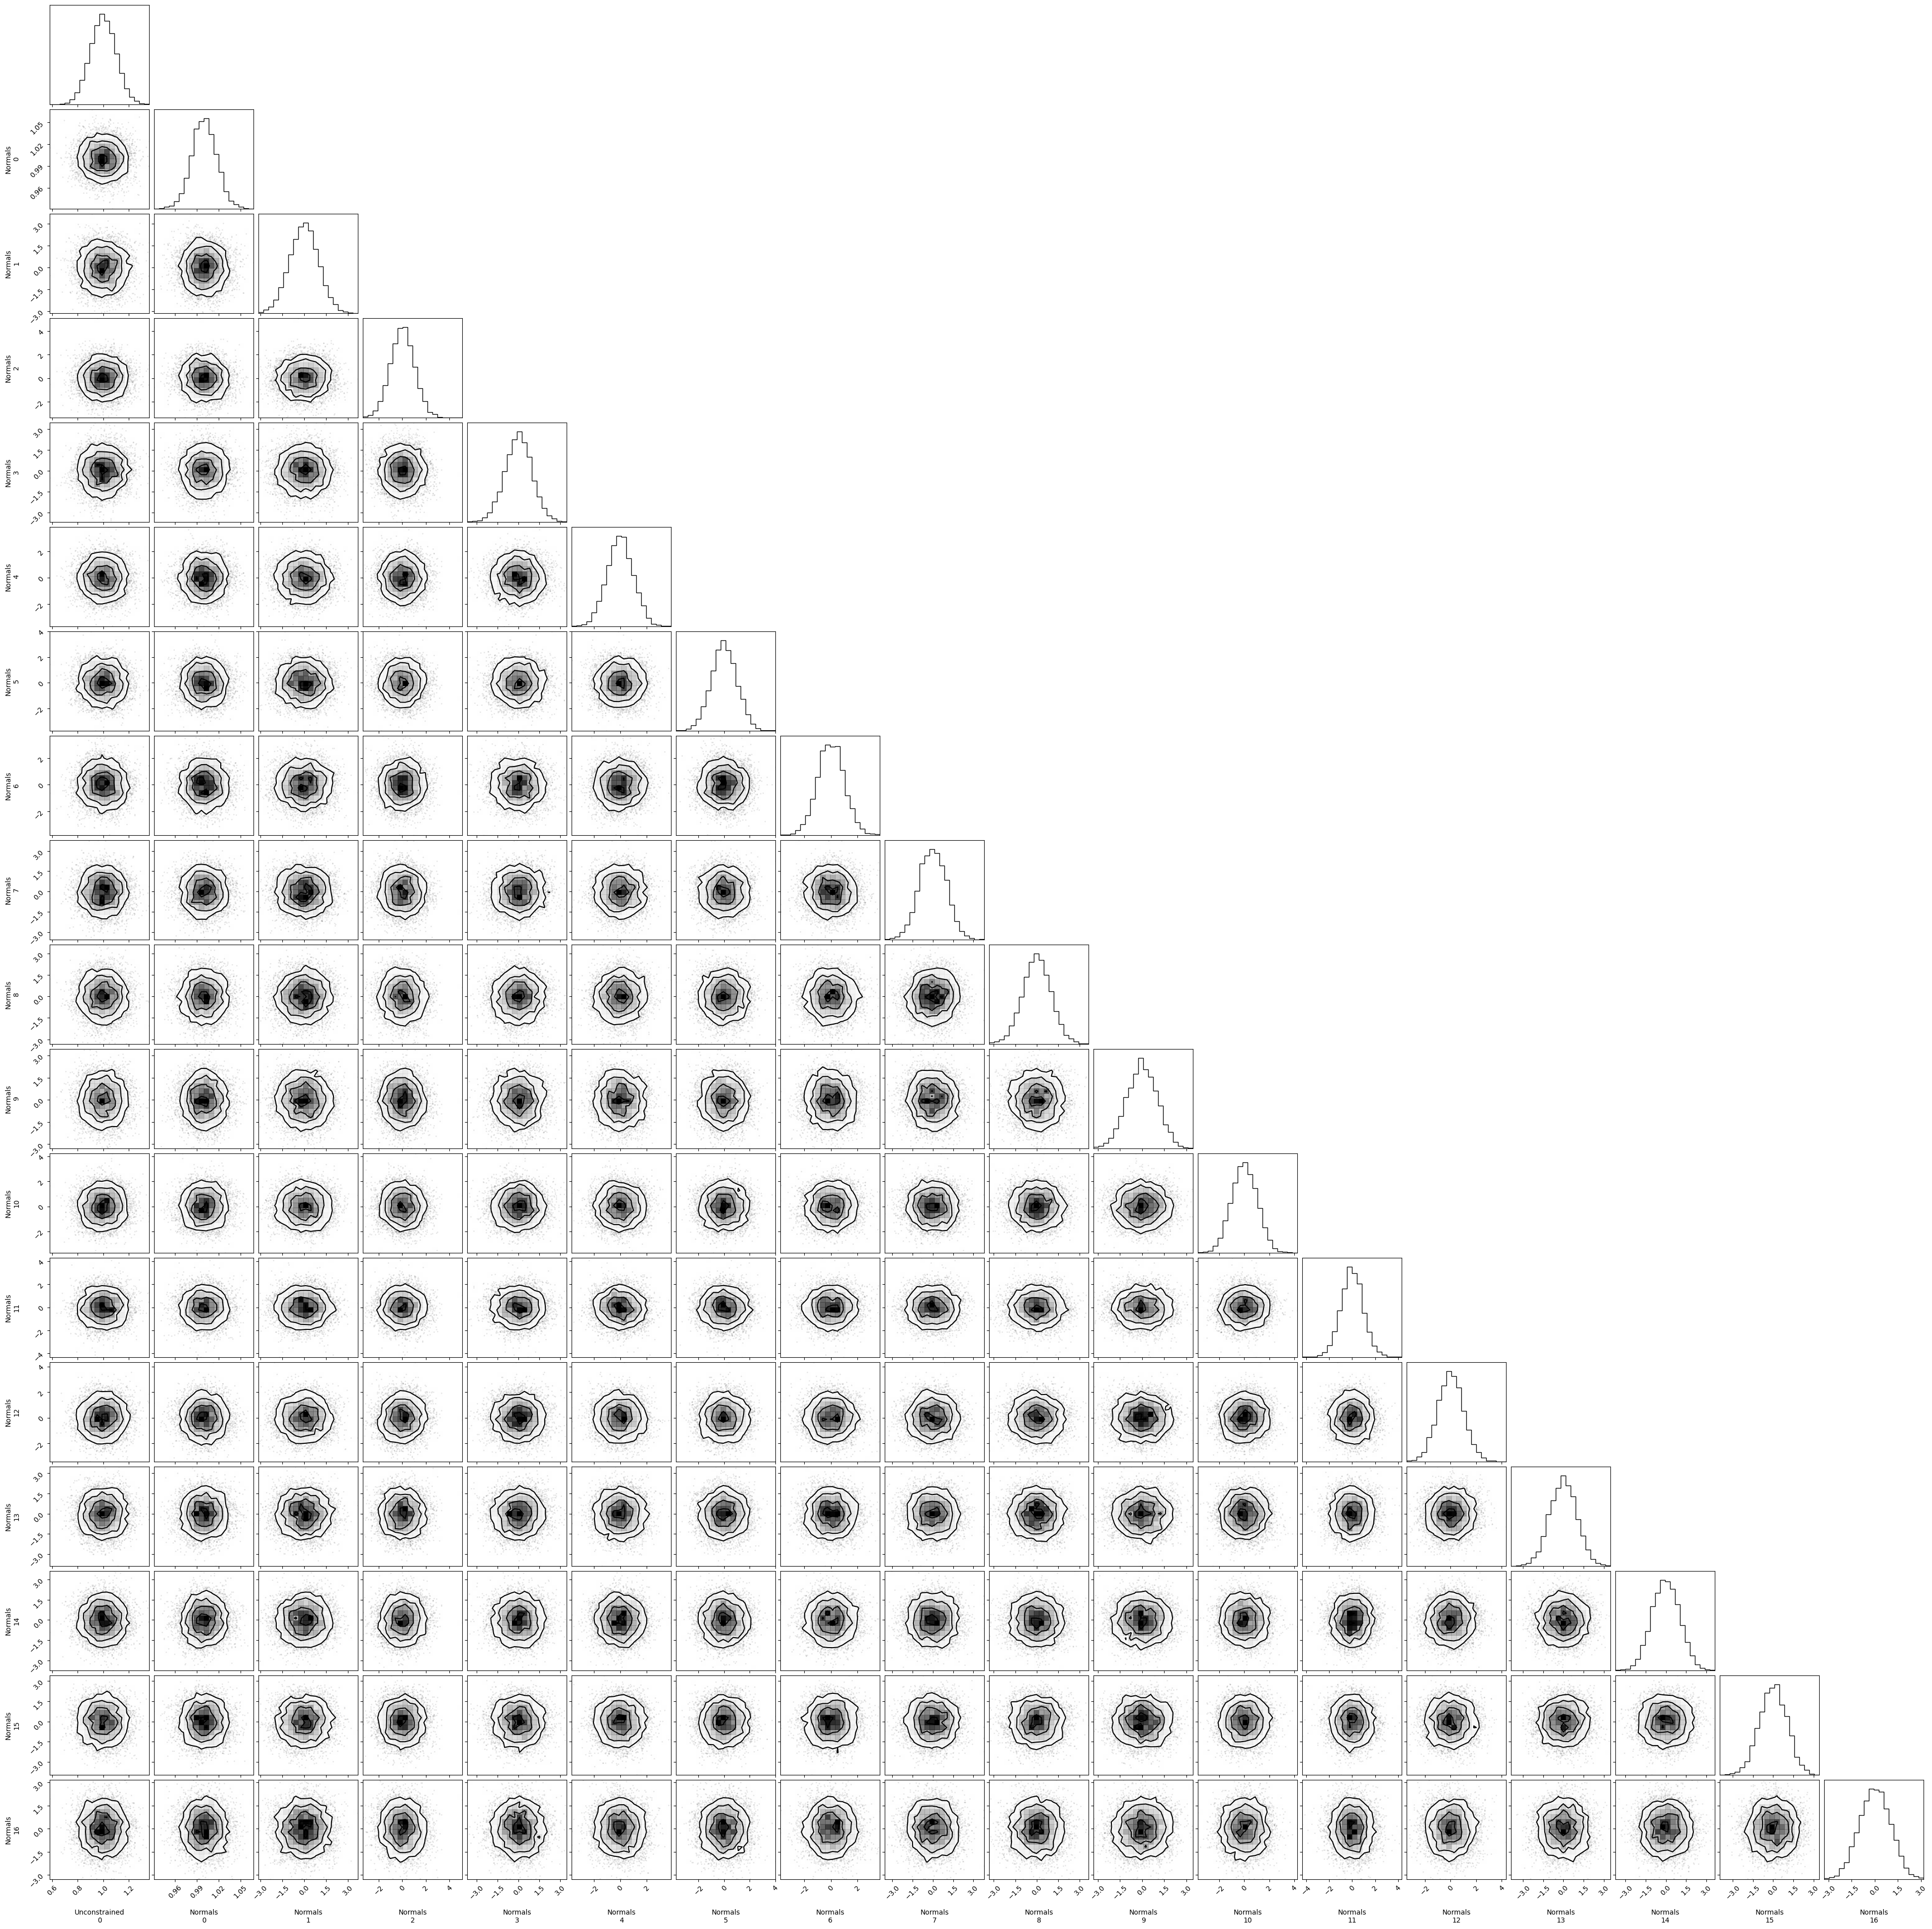

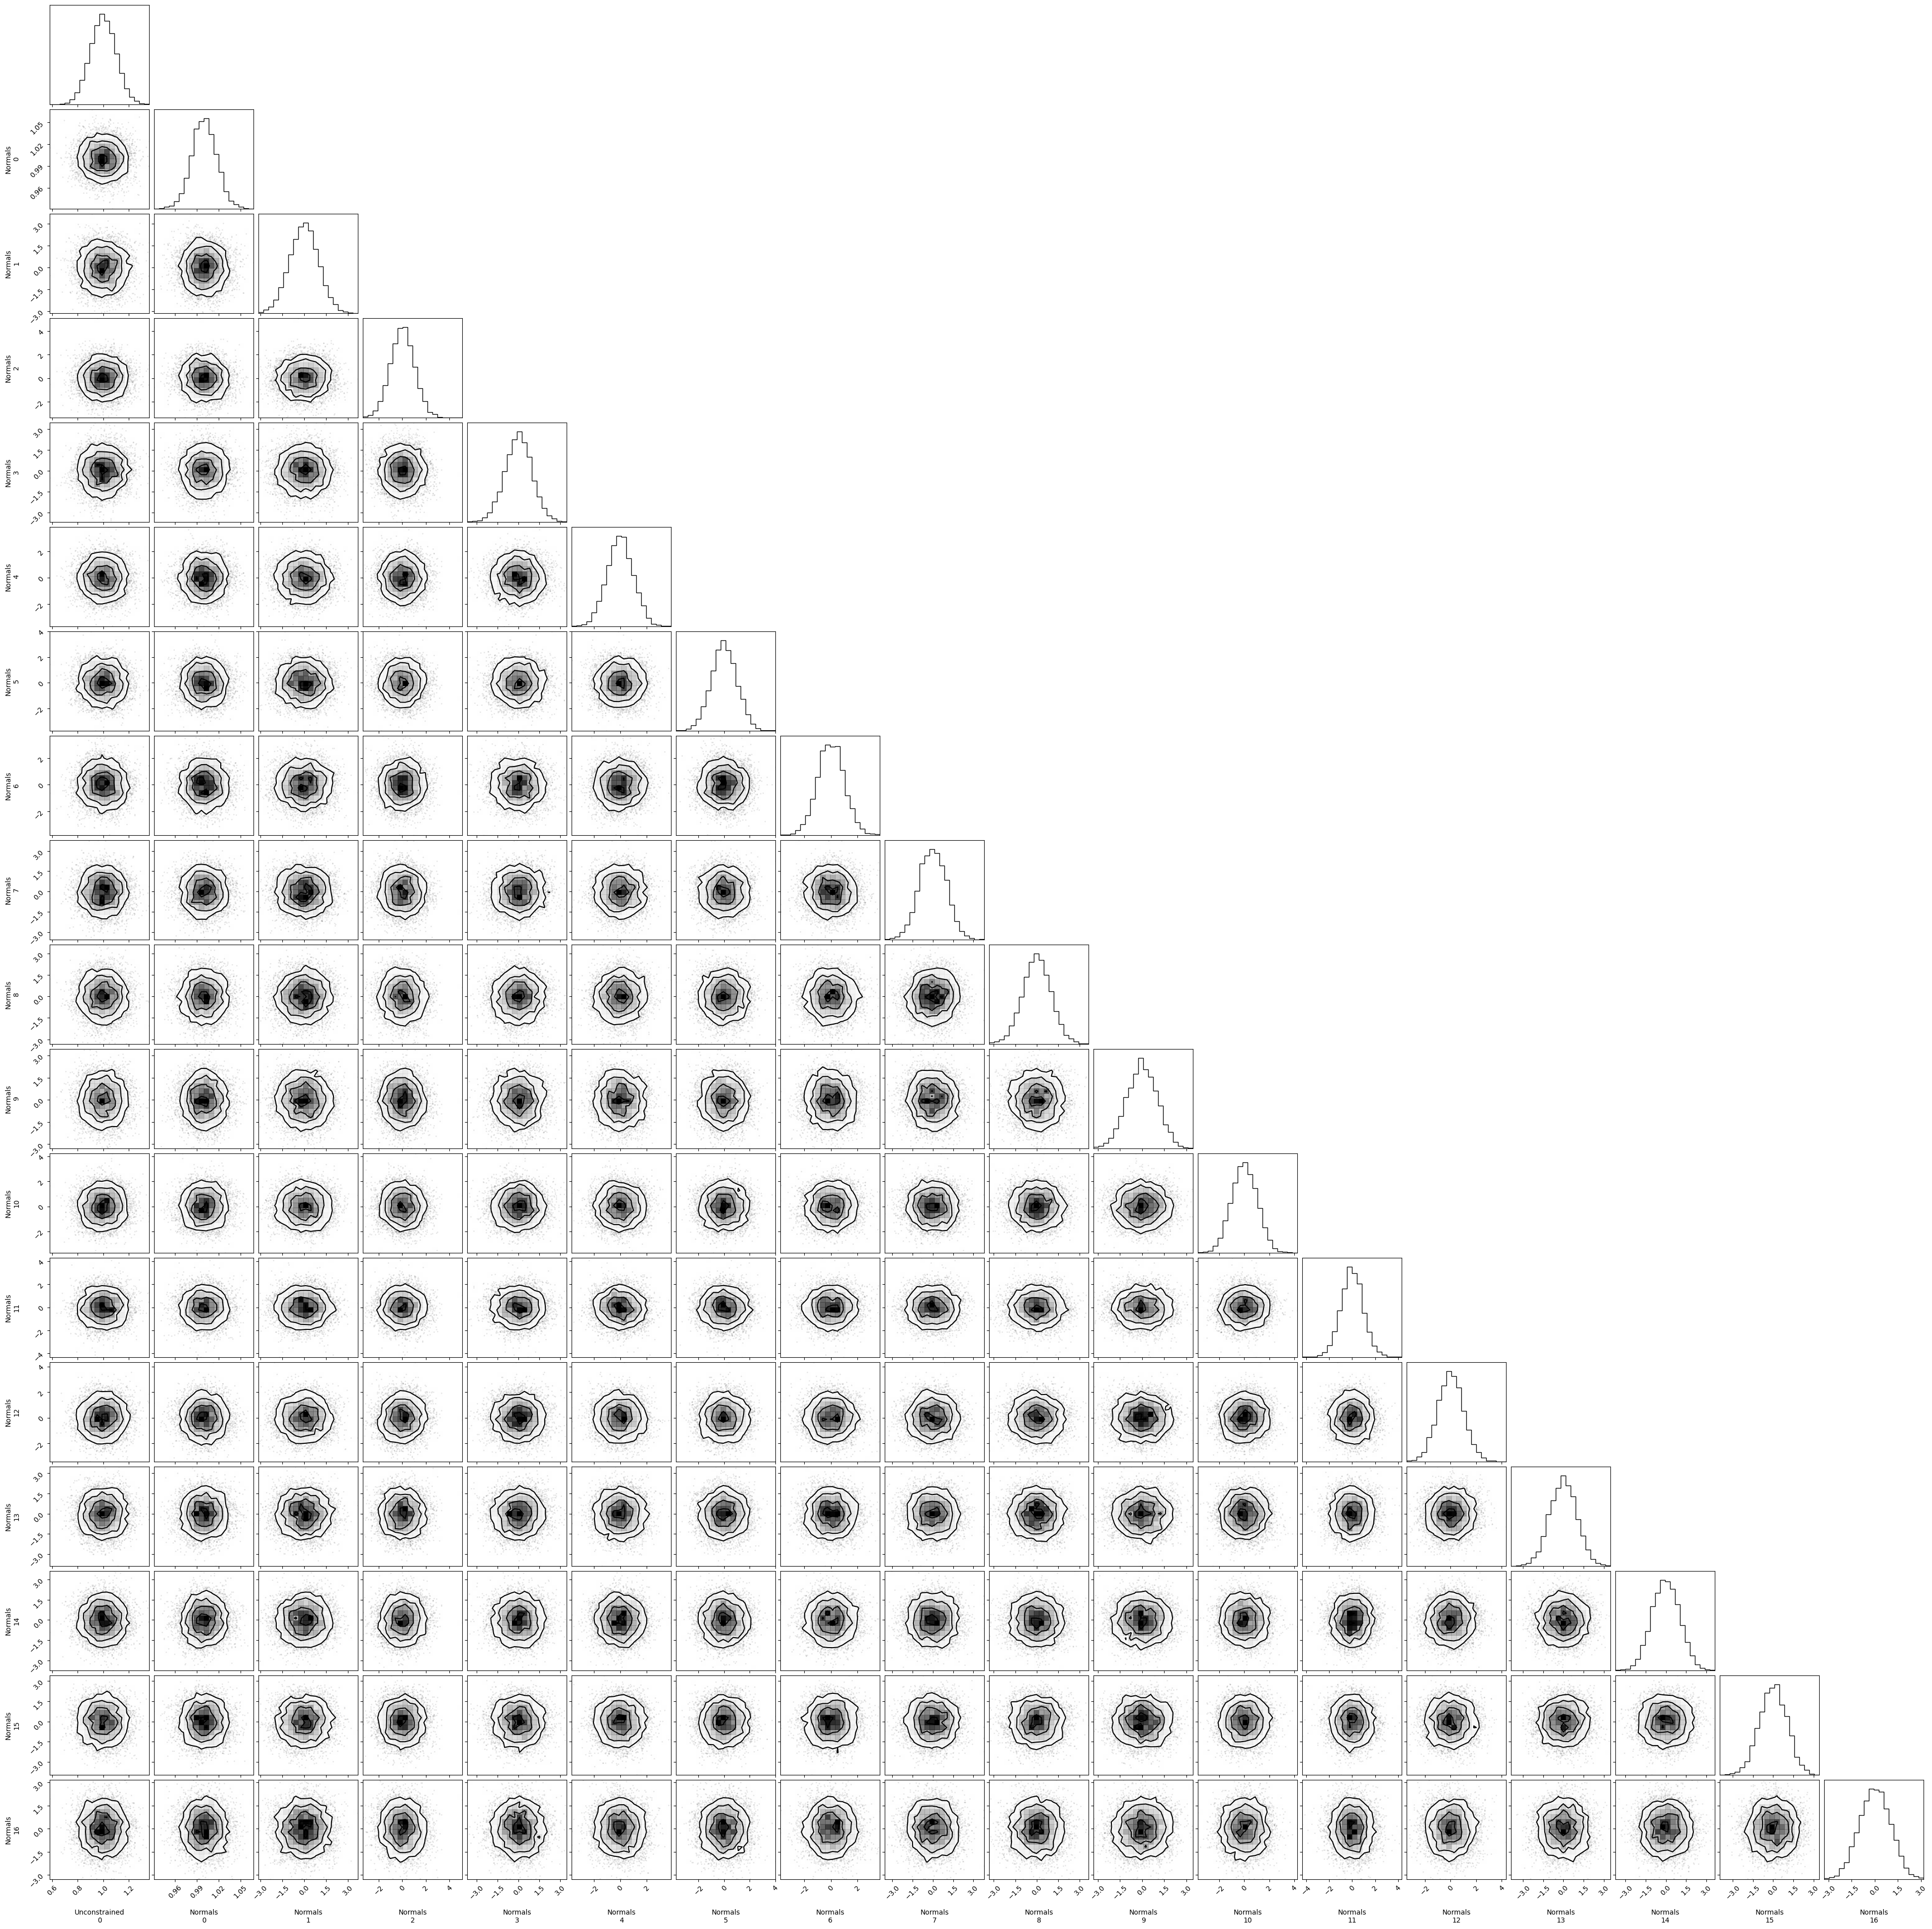

In [35]:
corner.corner(post_data)